<a href="https://colab.research.google.com/github/ms0017/GANs_exploration/blob/master/GANs_Faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Useful links for further GANs exploration:
# STYLEGAN 2 GITHUB REPO BY INVIDIA
https://github.com/NVlabs/stylegan2-ada-pytorch

# ORIGINAL STYLEGAN GITHUB REPO BY INVIDIA
https://github.com/NVlabs/stylegan

# USEFUL YOUTUBE VIDEO
https://www.youtube.com/watch?v=qEN-v6JyNJI&list=WL&index=5

#
https://towardsdatascience.com/style-transfer-with-gans-on-hd-images-88e8efcf3716
"""

'\nUseful links for further GANs exploration:\n# STYLEGAN 2 GITHUB REPO BY INVIDIA\nhttps://github.com/NVlabs/stylegan2-ada-pytorch\n\n# ORIGINAL STYLEGAN GITHUB REPO BY INVIDIA\nhttps://github.com/NVlabs/stylegan\n\n# USEFUL YOUTUBE VIDEO\nhttps://www.youtube.com/watch?v=qEN-v6JyNJI&list=WL&index=5\n'

In [ ]:
# Mount G-Drive on colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Next, clone StyleGAN2 ADA PyTorch from GitHub.
# This allows us to transfer weights from much bigger models instead of building from scratch
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!pip install ninja

fatal: destination path 'stylegan2-ada-pytorch' already exists and is not an empty directory.


In [ ]:
# Verify that StyleGAN has been cloned.
!ls /content/stylegan2-ada-pytorch/

calc_metrics.py  docker_run.sh	LICENSE.txt   README.md        train.py
dataset_tool.py  docs		metrics       style_mixing.py
dnnlib		 generate.py	projector.py  torch_utils
Dockerfile	 legacy.py	__pycache__   training


In [ ]:
# Import required packages
import sys
sys.path.insert(0, "/content/stylegan2-ada-pytorch")
import pickle
import os
import numpy as np
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import IPython.display
import torch
import dnnlib
import legacy
from tqdm.notebook import tqdm

In [ ]:
# This function takes short seed numbers "seed" eg 6600 and expands them into a 512 latent vector, which is a floating point value
# The seed value is easier to represent in code than a 512 value vector. However, while a small change to the latent vector 
# results in a small change to the image, even a small change to the seed value will produce a radically different image.
# One can think of the latent vector as the DNA
def seed2vec(G, seed):
  """
  seed2vec: converts seed to latent vector

  param G: 
  param seed: the specified seed

  return int: a latent vector
  """
  return np.random.RandomState(seed).randn(1, G.z_dim)

In [ ]:
def display_image(image):
  """
  display_image: displays input image

  param image: image to be displayed
  """
  plt.axis('off')
  plt.imshow(image)
  plt.show()

In [ ]:
'''
def generate_image(G, z, truncation_psi):
  """
  generate_image: generates image given params
  param G: Neural Net
  param z: 512 lantent vectors/ expanded seeds
  param truncation_psi: used by stylegan2 to make images clearer. Sets a threshold below or above which things get either blury or clearer
  """
  # Render images for dlatents initialized from random seeds.
  Gs_kwargs = {
      'output_transform': dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True),
      'randomize_noise': False
  }

  # Set truncation_psi if specified
  if truncation_psi is not None:
      Gs_kwargs['truncation_psi'] = truncation_psi

  label = np.zeros([1] + G.input_shapes[1][1:])
  images = G.run(z, label, **G_kwargs) # [minibatch, height, width, channel]
  display_image(images[0])
  return images[0]
  '''

'\ndef generate_image(G, z, truncation_psi):\n  """\n  generate_image: generates image given params\n  param G: Neural Net\n  param z: 512 lantent vectors/ expanded seeds\n  param truncation_psi: used by stylegan2 to make images clearer. Sets a threshold below or above which things get either blury or clearer\n  """\n  # Render images for dlatents initialized from random seeds.\n  Gs_kwargs = {\n      \'output_transform\': dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True),\n      \'randomize_noise\': False\n  }\n\n  # Set truncation_psi if specified\n  if truncation_psi is not None:\n      Gs_kwargs[\'truncation_psi\'] = truncation_psi\n\n  label = np.zeros([1] + G.input_shapes[1][1:])\n  images = G.run(z, label, **G_kwargs) # [minibatch, height, width, channel]\n  display_image(images[0])\n  return images[0]\n  '

In [ ]:
def get_label(G, device, class_idx):
  """
  get_label: given class dimensions and idx, labels are generated

  param G: pretrained model
  param device: device type
  param class_idx: set class id

  return label: defined label [tensor([], device='cuda:0', size=(1, 0))]
  """
  label = torch.zeros([1, G.c_dim], device=device)

  # class_idx are None and G.c_dim is 0
  # Checking model dimensions
  if G.c_dim != 0:
      if class_idx is None:
          ctx.fail('Must specify class label with --class when using a conditional network')
      # Set label to 1
      label[:, class_idx] = 1
  else:
      if class_idx is not None:
          print ('warn: --class=lbl ignored when running on an unconditional network')
  return label

In [ ]:
# G is the NN
# truncation_pis is used by stylegan2 to make images look better/ clearer
# noise affects random variables like hair placement. Think of how your hair looks on different days. set to 'const' so that it's fixed
def generate_image(device, G, z, truncation_psi=1.0, noise_mode='const', class_idx=None):
  """
  generate_image: generates image given params
  param G: Neural Net
  param z: 512 lantent vectors/ expanded seeds
  param truncation_psi: used by stylegan2 to make images clearer. Sets a threshold below or above which things get either blury or clearer
  param noise: affects random variables like hair placement. Think of how your hair looks on different days. Set to 'const' so that it's fixed
  param class_idx: specifies class label

  return image: generated image
  """
  # Extracts model
  z = torch.from_numpy(z).to(device)

  # Get class labels
  label = get_label(G, device, class_idx)
  
  # Generates image tensor
  img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)

  # Convert image tensor to png
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  # Save image to file
  #PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/seed{seed:04d}.png')
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

In [ ]:
# Takes seeds and expands them to 512 vectors
# Called by explore_seed function
def expand_seed(seeds, vector_size):
  print("seeds in expand seed")
  print(seeds)

  print("vector size")
  print(vector_size)

  result = []
  count = 1
  for seed in seeds:
    print("in seed", count)
    count += 1
    rnd = np.random.RandomState(seed)
    
    print("this is a sample complete vector:")
    print("############################")
    print(rnd.randn(1, vector_size))
    print("############################")

    print("it has a length of:", len(rnd.randn(1, vector_size)))

    result.append( rnd.randn(1, vector_size) ) 

  return result

In [ ]:
def download_torch_pretrained_instance(device):
  """
  download_torch_pretrained_instance: downloads instance of pretrained model from nvidia

  param device: device type
  return G: pretrained model
  """
  URL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
  print(f'Loading networks from "{URL}"...')
  with dnnlib.util.open_url(URL) as f:
      G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

  # Return model
  return G

In [ ]:
def get_images(G, device):
 
  """
  get_images: starts the process of image generation

  param G: pretrained model
  param device: device type
  """ 
  # Choose your own starting and ending seed.
  # The difference between start and end seeds represents the number of images that will be displayed
  SEED_FROM = 5
  SEED_TO = 10

  # Generate the images for the seeds.
  for i in range(SEED_FROM, SEED_TO):
    # Convert seeds to vector
    z = seed2vec(G, i)

    # Generate images given vector
    img = generate_image(device, G, z)

    # Display images to console
    display_image(img)
    print(f"Seed {i}")

In [ ]:
def explore_seed(G):
  vector_size = G.z_dim

  #seeds = expand_seed(range(8192,8300), vector_size)
  seeds = expand_seed([8192+1,8192+9], vector_size)
  #generate_images(Gs, seeds,truncation_psi=0.5)
  print("seeds shape")
  print(seeds[0].shape)

In [ ]:
def morph_video(G, device):
  # Choose your seeds to morph through and the 
  # number of steps to take to get to each.
  SEEDS = [2000,2003,2001]
  STEPS = 100

  # Remove any prior results
  !rm /content/results/* 
  os.makedirs("./results/", exist_ok=True)

  # Generate the images for the video.
  idx = 0
  for i in range(len(SEEDS)-1):
    v1 = seed2vec(G, SEEDS[i])
    v2 = seed2vec(G, SEEDS[i+1])

    diff = v2 - v1
    step = diff / STEPS
    current = v1.copy()

    for j in tqdm(range(STEPS), desc=f"Seed {SEEDS[i]}"):
      current = current + step
      img = generate_image(device, G, current)
      img.save(f'./results/frame-{idx}.png')
      idx+=1
  
  # Link the images into a video.
  !ffmpeg -r 30 -i /content/results/frame-%d.png -vcodec mpeg4 -y movie.mp4

In [ ]:
def download_video():
  from google.colab import files
  files.download('movie.mp4')

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...


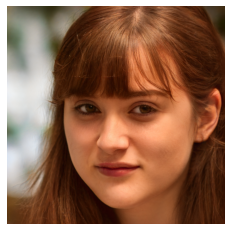

Seed 5


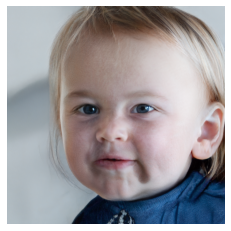

Seed 6


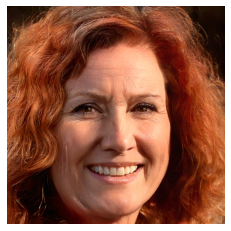

Seed 7


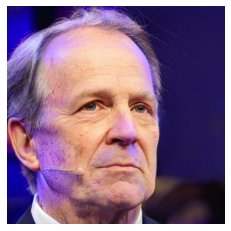

Seed 8


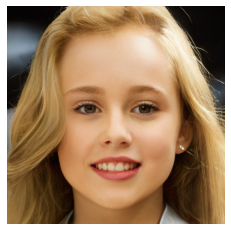

Seed 9
seeds in expand seed
[8193, 8201]
vector size
512
in seed 1
this is a sample complete vector:
############################
[[-7.87639208e-01  1.19904689e-01 -7.80395983e-02  1.63893966e+00
   1.69225773e+00 -5.17848756e-01 -3.66850212e-01 -1.16376065e-01
  -8.54743588e-01 -1.38595321e+00 -2.42472986e+00  4.99457830e-01
  -1.83777426e+00  4.21001414e-01  3.82451532e-01  3.00410082e-01
   2.00253322e-01 -5.73037985e-02 -1.03287605e+00 -1.94842081e+00
  -1.37661831e+00  5.11343315e-01  1.62458617e+00  1.01501055e-02
  -7.31920953e-02  2.27210094e-01 -4.77020383e-01  6.52755321e-01
  -1.73523885e-01  8.23188469e-01  1.24937693e-02 -1.28624582e+00
   7.06094843e-01  7.38849713e-02 -5.83901467e-01 -2.01451292e+00
   1.77886880e+00 -7.50165169e-01  2.86565830e-01  9.30083738e-01
  -9.50114622e-01  1.68563503e-01 -9.67521826e-01  9.40882734e-02
   7.30479809e-02 -1.87733592e-01  6.68475150e-01 -1.45023761e+00
   1.08392348e+00  4.98195833e-01  1.73440862e+00 -3.33201832e-01
  -2.2961778

Seed 2000:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 2003:   0%|          | 0/100 [00:00<?, ?it/s]

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
if __name__== "__main__":
    # Only works on cuda/ GPU machine
    device = torch.device('cuda')

    # Download pretrained model from NVIDIA
    G = download_torch_pretrained_instance(device)

    # Get images given model and device type
    get_images(G, device)

    explore_seed(G)
    morph_video(G, device)
    download_video()